In [1]:
import sys
sys.path.append('../src')
import numpy as np
from tqdm import tqdm
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_HVC = 600, 150, 20

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
aud_real = dict(np.load('learned_song_responses.npz')) # (n_songs, N, T)
N_in = aud_real['ctrl'].shape[1]
loc_in = np.linspace(0, 1, num=N_in, endpoint=False)
loc_E = np.linspace(0, 1, num=NE, endpoint=False)
mapping = np.exp(-(loc_in[:,None]-loc_E[None,:])**2/2e-5)
# mapping = rng.normal(size=(N_in, NE))
# p1 = 1/N_in
# mapping = rng.choice((-1, 0, 1), size=(N_in, NE), replace=True, p=(p1, 1-2*p1, p1))

In [5]:
for k in ('ctrl', 'pert'):
    # aud_real[k] = aud_real[k][:,:NE,:]
    # swap, project, and then swap back
    aud_real[k] = np.swapaxes(np.swapaxes(aud_real[k], 1, 2) @ mapping, 1, 2)
    # aud_real[k] = np.repeat(aud_real[k], NE//aud_real[k].shape[1], axis=1)
    aud_real[k] = aud_real[k] / aud_real[k].std() # normalize
    # aud_real[k] = aud_real[k] / aud_real[k].std(axis=1, keepdims=True) # normalize
    np.nan_to_num(aud_real[k], copy=False, nan=0)
    aud_real[k] = aud_real[k] * 2

[Text(0, 0.5, 'auditory input neuron'), Text(0.5, 0, 'excitatory neuron')]

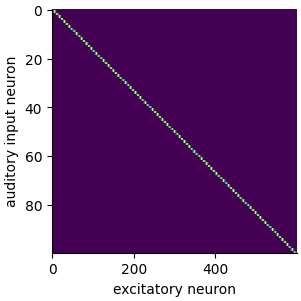

In [6]:
fig, ax = plt.subplots(1, figsize=(3,3))
ax.imshow(mapping, interpolation='none', aspect='auto')
ax.set(ylabel='auditory input neuron', xlabel='excitatory neuron')
# plt.plot(mapping[0,:10])

In [7]:
# plt.hist(aud_real['ctrl'].flatten(), bins=100);
# aud_real['ctrl'].max()

In [8]:
T_post = 100
T_song = aud_real['ctrl'].shape[2]
T_rend = T_song + T_post # Each rendition
N_rend = 30 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [9]:
aud_idx = rng.choice(np.arange(aud_real['ctrl'].shape[0]), size=N_rend)
aud = np.zeros((T, NE))
for i in range(N_rend):
    t0 = T_burn+i*T_rend
    aud[t0:t0+T_song] = aud_real['ctrl'][aud_idx[i]].T

In [10]:
_ = np.arange(N_rend)
burst_ts = np.linspace(_*T_rend+T_burn, _*T_rend+T_burn+T_song, num=N_HVC, endpoint=False)
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
save_W_ts = np.round(burst_ts[-1]).astype(int)

In [11]:
rH = generate_HVC(T, burst_ts, peak_rate+_*0.1, kernel_width+_*0.01)
# for i in range(rH.shape[1]):
#     plt.plot(rH[:T_burn+T_rend,i], c='k', alpha=0.1+0.9*i/rH.shape[1])

In [12]:
gen = lognormal_gen
# gen = const_gen
c = 0.3
JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.2, 0.6]) / 3
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
# c = 1
# JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.25, 0.9])
# sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)
J0_mean = JEE0 / np.sqrt(NE) * c

In [13]:
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [14]:
r_rest = 1 # target rate when phi(0)
rmax, s = 40, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [15]:
w0_mean, w0_std, cW = 1/N_HVC, 0/N_HVC, 1
w_inh, wI = w0_mean*cW, 0.0
tauE, tauI, dt = 40, 10, 1

netFF = WCNet(NE, N_HVC, w0_mean, phi, tauE, w_inh=w_inh, w0_std=1e-3)
netEI = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
              JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
              w_inh=w_inh, wI=wI, w0_std=1e-3, cW=cW)

Not a recurrent model and rI will not be calculated.


In [16]:
# rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
# rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
# _ = netEI.sim(rE0, rI0, rH[:T_burn+T_rend], aud[:T_burn+T_rend], [], T_burn+T_rend, dt, 0)
# rE = _[0]
# fig, ax = plt.subplots(3, sharex='all')
# ax[0].plot(rH[:T_burn+T_rend])
# ax[1].plot(aud[:T_burn+T_rend,:5])
# ax[2].plot(rE[:T_burn+T_rend,:50]);

In [17]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
plasticity_kwargs = dict(plasticity=bilin_hebb_E_HVC, lr=-1e-2, 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netFF.sim(rE0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
Ws_FF = _[2]
plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), lr=dict(HVC=-5e-2), 
                         tauW=1e5, asyn_H=0, rE_th=1)
_ = netEI.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
Ws_EI = _[2]['HVC']
if issparse(Ws_EI[0]):
    Ws_EI = [_.toarray() for _ in Ws_EI]

100%|███████████████████████████████████| 27499/27499 [00:06<00:00, 3955.96it/s]


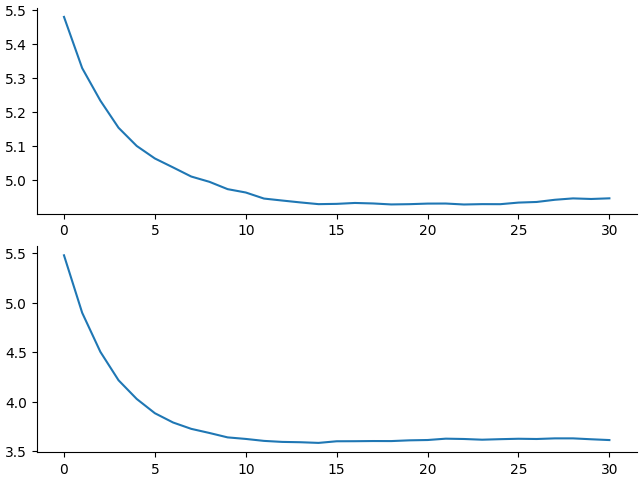

In [18]:
fig, ax = plt.subplots(2)
ax[0].plot([np.sqrt((_**2).sum()) for _ in Ws_FF])
ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws_EI])

In [19]:
def plot_corr_mat(Ws, sort=False, vmin=-1, vmax=1):
    corrs = [correlation(Ws[i].T, aud_real['ctrl'].mean(axis=0).T, dim=2) 
             for i in (0,-1)] \
          + [correlation(Ws[-1].T, aud_real['pert'].mean(axis=0).T, dim=2)]
    if sort:
        idx = np.argsort(np.nanargmin(corrs[1], axis=1))
    fig, ax = plt.subplots(1, 3, sharey='all', figsize=(5, 2))
    for i, j in enumerate(corrs):
        im = j if not sort else j[idx,:]
        im = ax[i].imshow(im, aspect='auto', interpolation='none', 
                          vmin=vmin, vmax=vmax, cmap='seismic')
    ax[0].set_title('Before learning\ncorrect song')
    ax[1].set_title('After learning\ncorrect song')
    ax[2].set_title('After learning\nperturbed song')
    cax = fig.colorbar(im, ax=ax, label='Correlation', ticks=[vmin, 0, vmax])
    return fig, ax

/home/zg93/Projects/Aiv-Network/learn_realistic_auditory_processing/../src/utils.py:56: RuntimeWarning: invalid value encountered in divide
  return (sig - m) / s


[Text(0, 0.5, 'HVC index'),
 Text(0.5, 0, 'Time (ms)')]

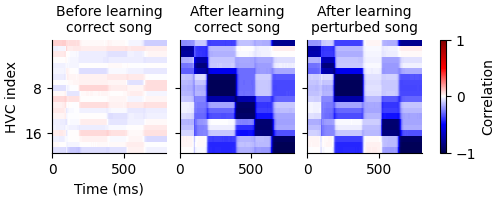

In [20]:
fig, ax = plot_corr_mat(Ws_FF)
ax[0].set(ylabel='HVC index', yticks=[8, 16], xlabel='Time (ms)')

[Text(0, 0.5, 'HVC index'),
 Text(0.5, 0, 'Time (ms)')]

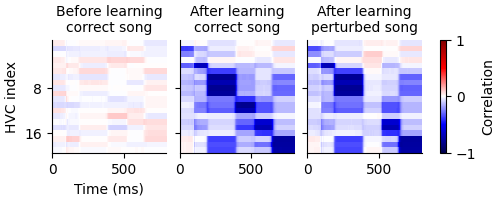

In [21]:
fig, ax = plot_corr_mat(Ws_EI)
ax[0].set(ylabel='HVC index', yticks=[8, 16], xlabel='Time (ms)')

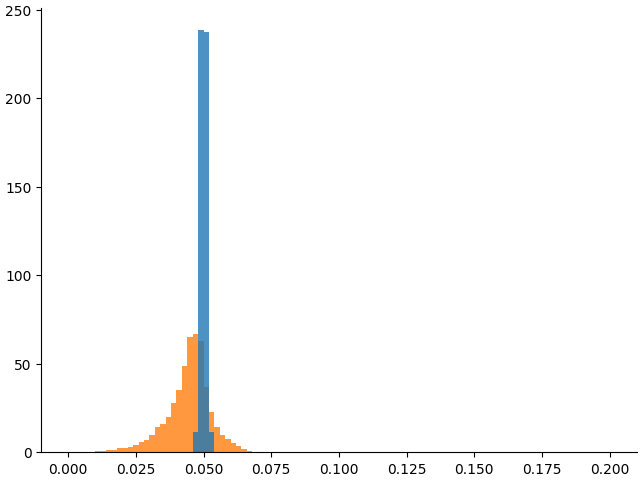

In [22]:
plt.hist([Ws_FF[0].flatten(), Ws_FF[-1].flatten()], density=True, bins=100, 
         range=(0, 0.2), histtype='stepfilled', alpha=0.8);

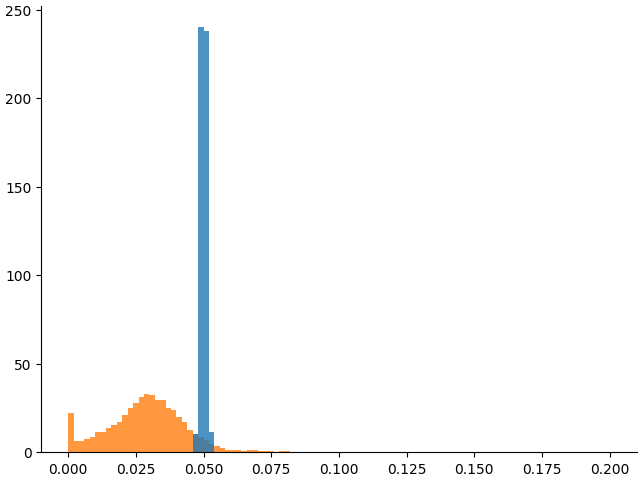

In [23]:
plt.hist([Ws_EI[0].flatten(), Ws_EI[-1].flatten()], density=True, bins=100, 
         range=(0, 0.2), histtype='stepfilled', alpha=0.8);

In [24]:
gen = lognormal_gen
# gen = const_gen
c = 0.5
JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.2, 0.6]) / 3
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
# c = 1
# JEE0, JEI0, JIE0, JII0 = np.array([1, 0.8, 1.25, 0.9])
# sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.25
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)
J0_mean = JEE0 / np.sqrt(NE) * c

In [25]:
w0_mean, w0_std, cW = 2/N_HVC, 0/N_HVC, 0.05
w_inh, wI = w0_mean*cW, 0.0
tauE, tauI, dt = 40, 10, 1

netEIrec = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, 
                 JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                 w_inh=w_inh, wI=wI, w0_std=w0_std, cW=cW)

In [26]:
# rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
# rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
# _ = netEIrec.sim(rE0, rI0, rH[:T_burn+T_rend], aud[:T_burn+T_rend], [], T_burn+T_rend, dt, 1)
# rE = _[0]
# fig, ax = plt.subplots(3, sharex='all')
# ax[0].plot(rH[:T_burn+T_rend])
# ax[1].plot(aud[:T_burn+T_rend,:5])
# ax[2].plot(rE[:T_burn+T_rend,:5]);

In [27]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
plasticity_kwargs = dict(plasticity=dict(JEE=bilin_hebb_EE), lr=dict(JEE=-5e-1), 
                         tauW=1e5, J0_mean=J0_mean, asyn_E=10, rE_th=1)
_ = netEIrec.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
rE, rI, Ws, mean_HVC_input, hE = _
Ws = Ws['JEE']
if issparse(Ws[0]):
    Ws = [_.toarray() for _ in Ws]

100%|███████████████████████████████████| 27499/27499 [00:24<00:00, 1141.09it/s]


[Text(0, 0.5, 'E index'), Text(0.5, 0, 'Time (ms)')]

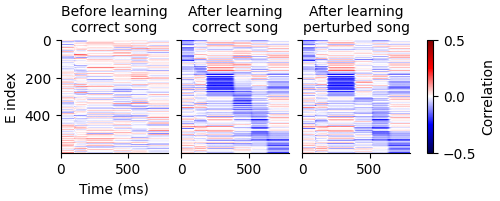

In [28]:
fig, ax = plot_corr_mat(Ws, sort=True, vmin=-0.5, vmax=0.5)
ax[0].set(ylabel='E index', xlabel='Time (ms)')

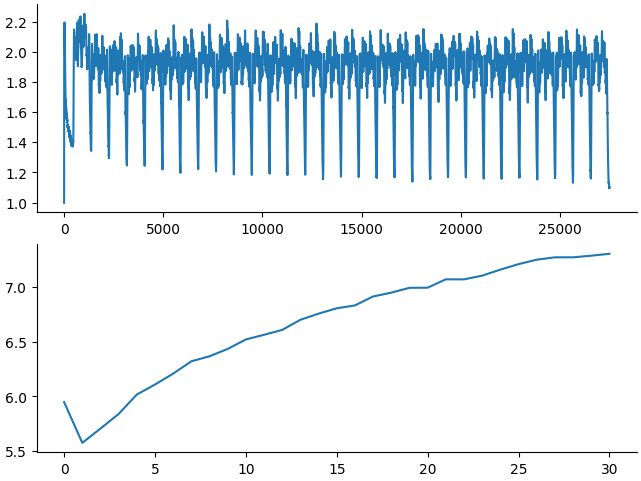

In [29]:
fig, ax = plt.subplots(2)
ax[0].plot(rE.mean(axis=-1))
ax[1].plot([np.sqrt((_**2).sum()) for _ in Ws])

## Testing

In [30]:
N_test_rend = 20
T_test = T_burn+T_rend*N_test_rend
_ = np.arange(aud_real['pert'].shape[0])
aud_pert_idx = rng.choice(np.arange(aud_real['pert'].shape[0]), size=N_test_rend)
aud_pert = np.zeros((T_test, NE))
for i in range(N_test_rend):
    t0, t1 = T_burn+i*T_rend, T_burn+i*T_rend+T_song
    aud_pert[t0:t1] = aud_real['pert'][aud_pert_idx[i]].T

In [31]:
def parse_trial(r):
    ret = np.zeros((N_test_rend, T_rend, r.shape[-1]))
    for i in range(N_test_rend):
        ret[i] = r[T_burn+i*T_rend:T_burn+(i+1)*T_rend]
    return ret

In [32]:
rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
res = dict(ctrl=[], pert=[], deaf=[])
for k, a in zip(('ctrl', 'pert', 'deaf'), (aud[:T_test], aud_pert, aud_pert*0)):
    res[k].append(parse_trial(netFF.sim(rE0, rH[:T_test], a, [], T_test, dt, 1)[0]))
    res[k].append(parse_trial(netEI.sim(rE0, rI0, rH[:T_test], a, [], T_test, dt, 1)[0]))
    res[k].append(parse_trial(netEIrec.sim(rE0, rI0, rH[:T_test], a, [], T_test, dt, 1)[0]))

100%|███████████████████████████████████| 18499/18499 [00:05<00:00, 3667.43it/s]


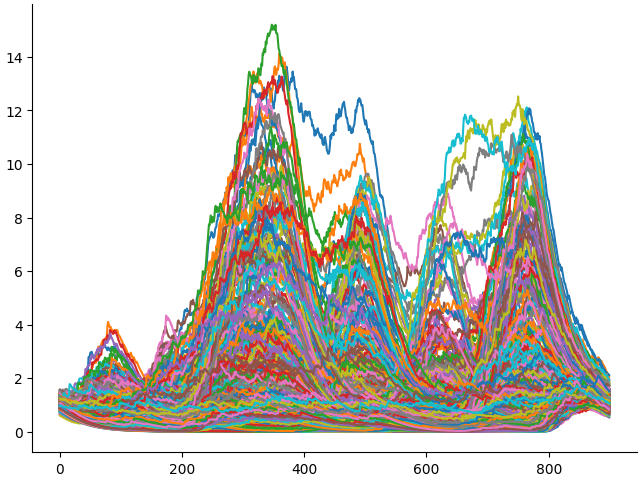

In [33]:
plt.plot(res['deaf'][0][0,:,:]);

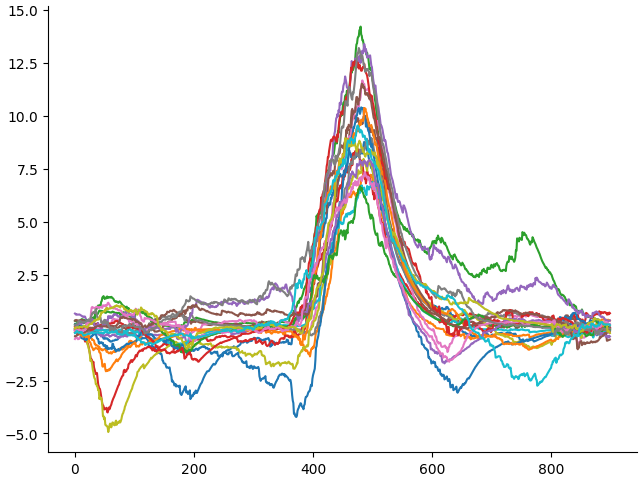

In [34]:
i = 0
diff = res['pert'][i] - res['ctrl'][i]
# diff = res['deaf'][0] - res['ctrl'][0]
plt.plot(diff[:,:,2].T);
# plt.plot(diff[:,:,:].mean(axis=0), color='k', alpha=0.1);
# plt.plot(diff[:,:,:].mean(axis=(0,2)), color='r');

In [35]:
print(aud_real['pert_t0'].mean(), aud_real['pert_t1'].mean())
T0, T1 = 280, 530
T = res['ctrl'][0].shape[1]

383.10694786634247 433.10694786634247


[Text(0, 0.5, 'EI network\n(E$\\to$E plasticity)')]

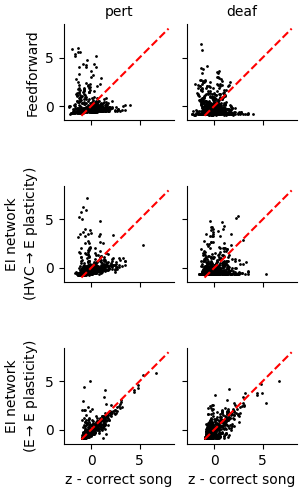

In [36]:
fig, ax = plt.subplots(3, 2, sharex='all', sharey='all', figsize=(3, 5))
for i in range(3): 
    z_ctrl = normalize(res['ctrl'][i][:,T0:T1].mean(axis=(0,1)), axis=0)
    for j, k in enumerate(('pert', 'deaf')):
        z_pert = normalize(res[k][i][:,T0:T1].mean(axis=(0,1)), axis=0)
        ax[i,j].plot(z_ctrl, z_pert, 'o', ms=1, c='k')
        ax[i,j].plot([-1, 8], [-1,8], c='r', ls='--')
        ax[i,j].set(aspect=1)
        ax[0,j].set_title(k, fontsize=10)
        ax[-1,j].set(xlabel='z - correct song')
ax[0,0].set(ylabel='Feedforward')
ax[1,0].set(ylabel='EI network\n(HVC$\\to$E plasticity)')
ax[2,0].set(ylabel='EI network\n(E$\\to$E plasticity)')

[Text(0, 0.5, 'EI network\n(E$\\to$E plasticity)')]

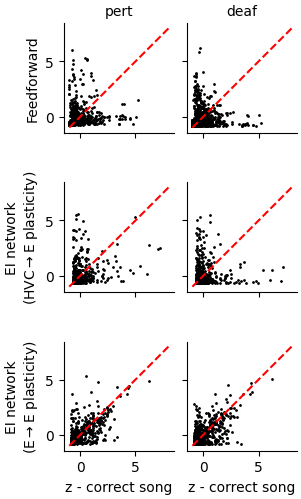

In [37]:
fig, ax = plt.subplots(3, 2, sharex='all', sharey='all', figsize=(3, 5))
for i in range(3): 
    z_ctrl = normalize(res['ctrl'][i][1,T0:T1].mean(axis=0), axis=0)
    for j, k in enumerate(('pert', 'deaf')):
        z_pert = normalize(res[k][i][1,T0:T1].mean(axis=0), axis=0)
        ax[i,j].plot(z_ctrl, z_pert, 'o', ms=1, c='k')
        ax[i,j].plot([-1, 8], [-1,8], c='r', ls='--')
        ax[i,j].set(aspect=1)
        ax[0,j].set_title(k, fontsize=10)
        ax[-1,j].set(xlabel='z - correct song')
ax[0,0].set(ylabel='Feedforward')
ax[1,0].set(ylabel='EI network\n(HVC$\\to$E plasticity)')
ax[2,0].set(ylabel='EI network\n(E$\\to$E plasticity)')

In [38]:
# from scipy.stats import permutation_test
# p_vals_pert = np.zeros((3, NE, 3)) # 3 models; before, during, and after pert
# def statistic(x, x_ctrl, diff):
#     return correlation(x, diff, dim=1) - correlation(x_ctrl, diff, dim=1)
# for l in range(3): # three models
#     diff = res['pert'][l] - res['ctrl'][l]
#     for j, (ti, tj) in enumerate(((0, T0), (T0, T1), (T1, T))):
#         for i in tqdm(range(NE)):
#             data = [res[k][l][:,ti:tj,i].mean(axis=1) for k in ('pert','ctrl')]
#             aux = lambda x, x_ctrl: statistic(x, x_ctrl, diff[:,ti:tj,i].mean(axis=1))
#             perm_test = permutation_test(data, statistic=aux, 
#                                          permutation_type='independent', 
#                                          n_resamples=1e3-1, alternative='greater')
#             p_vals_pert[l,i,j] = perm_test.pvalue

Text(0, 0.5, 'Perturbed\nresponse')

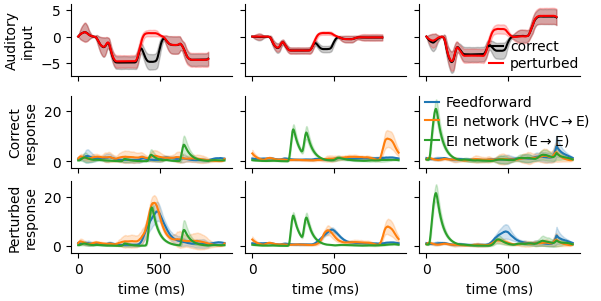

In [39]:
def plot_mean_std(ax, mean, std, a_fill, c, label):
    ts = np.arange(len(mean))
    ax.fill_between(ts, mean+std, mean-std, color=c, alpha=a_fill)
    return ax.plot(ts, mean, c=c, label=label)
ks = ('Feedforward', 'EI network (HVC$\\to$E)', 'EI network (E$\\to$E)')
fig, ax = plt.subplots(3, 3, sharex='all', sharey='row', figsize=(6, 3))
for j, l in enumerate((1, 3, 5)):
    plot_mean_std(ax[0,j], aud_real['ctrl'][:,l,:].mean(axis=0), 
                  aud_real['ctrl'][:,l,:].std(axis=0), a_fill=0.2, c='k', label='correct')
    plot_mean_std(ax[0,j], aud_real['pert'][:,l,:].mean(axis=0), 
                  aud_real['pert'][:,l,:].std(axis=0), a_fill=0.2, c='r', label='perturbed')
    for i, k in enumerate(ks):
        c = 'C%d' % i
        # if (i != 0 and j == 1) or (i == 0 and j == 2):
        #     k = ''
        _ = res['ctrl'][i][:,:,l]
        ls = plot_mean_std(ax[1,j], _.mean(axis=0), _.std(axis=0), a_fill=0.2, c=c, label=k)
        _ = res['pert'][i][:,:,l]
        ls = plot_mean_std(ax[2,j], _.mean(axis=0), _.std(axis=0), a_fill=0.2, c=c, label=k)
    ax[-1,j].set(xlabel='time (ms)')
ax[0,-1].legend(loc=(0.4, 0))
# ax[1,1].legend()
ax[1,-1].legend(loc=(0, 0.2))
ax[0,0].set_ylabel('Auditory\ninput')
ax[1,0].set_ylabel('Correct\nresponse')
ax[2,0].set_ylabel('Perturbed\nresponse')

In [ ]:
# from scipy.stats import permutation_test
# p_vals_pert = np.zeros((3, NE, 3)) # 3 models; before, during, and after pert
# def statistic(x, x_ctrl, diff, axis):
#     assert axis in (0, 1, -1), axis
#     if axis == 0:
#         x, x_ctrl, diff = x.T, x_ctrl.T
#     return correlation(x, diff[None,:], dim=1) - correlation(x_ctrl, diff[None,:], dim=1)
# for l in range(3): # three models
#     diff = res['pert'][l] - res['ctrl'][l]
#     for j, (ti, tj) in enumerate(((0, T0), (T0, T1), (T1, T))):
#         for i in tqdm(range(NE)):
#             data = [res[k][l][:,ti:tj,i].mean(axis=1) for k in ('pert','ctrl')]
#             aux = lambda x, x_ctrl, axis: \
#                   statistic(x, x_ctrl, diff[:,ti:tj,i].mean(axis=1), axis)
#             perm_test = permutation_test(data, statistic=aux, 
#                                          permutation_type='independent', 
#                                          n_resamples=1e3-1, alternative='greater')
#             p_vals_pert[l,i,j] = perm_test.pvalue